In [68]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import geopandas

from werkzeug.wrappers import Request, Response
from jinja2 import Template
import collections

from amigocloud import AmigoCloud
from shapely import wkb
import contextily as ctx

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

import requests

In [15]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [4]:
ruta

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [96]:
query_new = {'query' : 'select id, canhero from dataset_292618 where canhero is not null and (link_informe is null or link_informe=\'\')'}
project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
select_new = amigocloud.get(project, query_new)

In [97]:
select_new['data']

[{'id': 110, 'canhero': '40256 / INSERVA DAMIANA S.R.L.'},
 {'id': 89, 'canhero': '7506 / LOHENER ROSENDA SHEILA PAZ DE'},
 {'id': 90, 'canhero': '5011 / FRANCO ARIAS GREGORIO'}]

In [98]:
df_select = pd.DataFrame(select_new['data'])

In [99]:
df_select

,id,canhero
0,110,40256 / INSERVA DAMIANA S.R.L.
1,89,7506 / LOHENER ROSENDA SHEILA PAZ DE
2,90,5011 / FRANCO ARIAS GREGORIO


110
end
[{'lote': 'L2.2', 'file_name': 'Captura de pantalla 2023-09-09 172236.jpg'}]
https://www-amigocloud.s3.amazonaws.com/gallery/Captura de pantalla 2023-09-09 172236.jpg
89
end
[{'lote': 'L9', 'file_name': 'WhatsApp Image 2023-07-31 at 3.26.51 PM.jpeg'}]
https://www-amigocloud.s3.amazonaws.com/gallery/WhatsApp Image 2023-07-31 at 3.26.51 PM.jpeg
90
end
[{'lote': 'L10', 'file_name': 'WhatsApp Image 2023-08-01 at 2.05.10 PM.jpeg'}]
https://www-amigocloud.s3.amazonaws.com/gallery/WhatsApp Image 2023-08-01 at 2.05.10 PM.jpeg


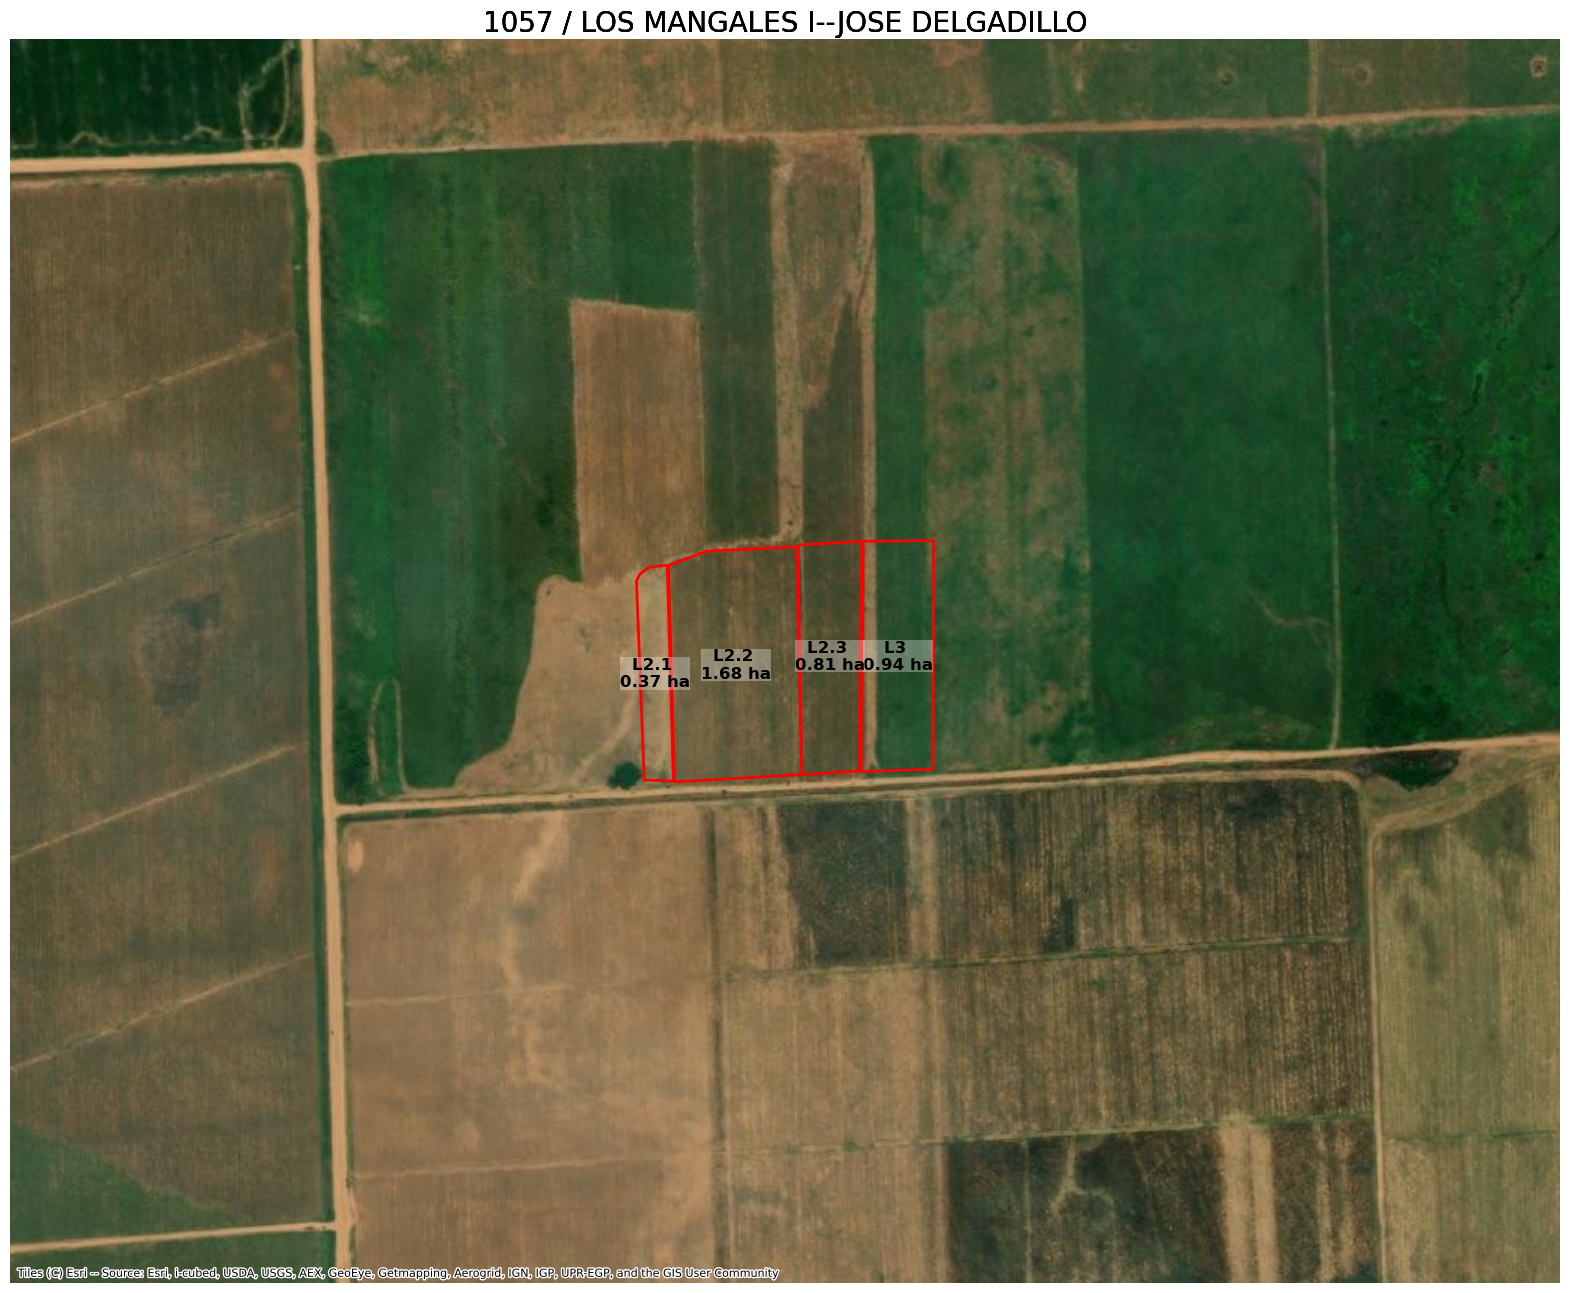

In [132]:
for i, r in df_select.iterrows():
    print(r[0])
    id = r[0]
    inspeccion = get_inspeccion(id)
    propiedad = get_propiedad(inspeccion.amigo_id)
    fotos = get_fotos(id)
    lista_planos = get_planos(propiedades)
    get_reporte(inspeccion, propiedades, fotos, lista_planos)

In [94]:
def get_inspeccion(id):
    # DATOS DE LAS INPECCION
    query = {'query': 'select CURRENT_DATE, * from dataset_292618 where id = {id}'.format(id=id)}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    select = amigocloud.get(project, query)
    data = select['data'][0]
    data['date'] = datetime.strptime(data['date'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
    data['fecha_quema'] = datetime.strptime(data['fecha_quema'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
    data['fecha_inspeccion'] = datetime.strptime(data['fecha_inspeccion'][0:10], '%Y-%m-%d').strftime('%d/%m/%Y')
    insp = collections.namedtuple("insp", data.keys())(*data.values())
    return insp

In [93]:
def get_propiedad(amigo_id):
    # DATOS DE LA PROPIEDAD
    # buscar propiedades de la inspeccion
    query = {'query': 'select * from dataset_293179 where insp_ref_prop = \'{insp_ref_prop}\''.format(insp_ref_prop=amigo_id)}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    select = amigocloud.get(project, query)
    propiedades_data = select['data']
    # lista general de propiedades
    propiedades = []
    for prop in propiedades_data:
        prop['lote'] = []
        query_lotes = {'query': 'select * from dataset_293180 where prop_ref_lote = \'{prop_ref_lote}\''.format(prop_ref_lote=prop['amigo_id'])}
        project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
        lotes_select = amigocloud.get(project, query_lotes)
        for lote_select in lotes_select['data']:
            lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
            prop['lote'].append(lote)
        propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))
    return propiedades

In [92]:
def get_fotos(id):
    # selecciona todas las fotos y nombre de lotes basado en el id de la inspeccion
    query_fotos = {'query': 'select l.lote, g.s3_filename file_name from gallery_42303 g\
                                inner join dataset_293180 l on l.amigo_id = g.source_amigo_id\
                                inner join dataset_293179 p on p.amigo_id = l.prop_ref_lote\
                                inner join dataset_292618 i on i.amigo_id = p.insp_ref_prop\
                                where i.id = {src_id}'.format(src_id=id)}
    project = 'https://app.amigocloud.com/api/v1/projects/31874/sql'
    select = amigocloud.get(project, query_fotos)
    fotos = select['data']
    return fotos

In [120]:
def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)[0]

def get_planos(propiedades):
    i = 0
    lista_planos = []
    path = ''
    for propiedad in propiedades:
        i = i + 1
        lotes_lista = []
        for lote in propiedad.lote:
            lotes_lista.append(lote._asdict())
        df = pd.DataFrame(lotes_lista)
        df['geometria'] = df['geometria'].apply(convertir_wkb)

        #Convertir a GeoDataFrame
        data = geopandas.GeoDataFrame(df, geometry='geometria')

        data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
        data['coords'] = [coords[0] for coords in data['coords']]
        
        data.crs = "EPSG:4326"
        data = data.to_crs(epsg=3857)
        
        fig = plt.figure(i, figsize=(20,20))
        ax = None
        ax = fig.add_subplot()

        data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

        minx, miny, maxx, maxy = data.total_bounds
        ax.set_xlim(minx - 500, maxx + 500)
        ax.set_ylim(miny - 400, maxy + 400)

        data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
        ax.set_axis_off()
        ax.set_title(str(propiedad.propiedad), fontsize=20)
        path = ruta + '/planos/' + str(insp.amigo_id) + '_' + str(propiedad.amigo_id) + '.jpeg'
        lista_planos.append(path)
    fig.savefig(path, dpi = 300, bbox_inches='tight')
    del fig
    return lista_planos

In [133]:
def get_reporte(insp, propiedades, fotos, lista_planos):
    #crea una instancia del template
    doc = DocxTemplate(ruta + "/templates/tpl_infome_quema.docx")
    #generar lista de InlineImage de planos 
    lista_InlineImage = []
    for plano in lista_planos:
        lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

    #descargar fotos y generar lista InlineImage
    lista_fotos_inline = []
    for foto in fotos:
        response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
        file = open(ruta + '/fotos/' + foto['file_name'], "wb")
        file.write(response.content)
        file.close()
        lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor= ruta + '/fotos/' + foto['file_name'], width=Mm(120)), 'lote': foto['lote']})

    firma_respon = None
    if insp.responsable == 'Rogelio Acuña Rodríguez':
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_rogelio.png', width=Mm(60))
    else:
        firma_respon = docxtpl.InlineImage(doc, image_descriptor=ruta + '/templates/firma_jaldin.png', width=Mm(60))

    context = {'insp':insp, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

    doc.render(context)

    # formato de nombre de archivo: "123_CAQ_01-01-2022_NOMBRE"
    cod_nom = insp.canhero.split(' / ')
    file_name = cod_nom[0] + '_CAQ_' + insp.fecha_inspeccion.replace('/','-') + '_' + cod_nom[1] + '_' + str(insp.id)

    doc.save(ruta + '/informes/_' + file_name + '.docx')